In [55]:
import numpy as np
import geopandas as gpd
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source

In [5]:
def missing_and_unique(df, col):
    n_missing = df[col].isna().sum()
    unique_vals = df[col].unique()
    print(f'Number of missing values: {n_missing}')
    print(f'Number of unique values: {len(unique_vals)}')
    print('They are:', unique_vals)

# Pre-Processing

In [6]:
# read files
df_filtered = gpd.read_file('./data/network/trt_network_filtered.shp')
df_easy_features = gpd.read_file('./data/network/network_w_easy_features.shp')

In [7]:
# process the easy feature file
df_easy_features.loc[24513, 'LTS'] = 4
df_easy_features = df_easy_features[df_easy_features['length_in_'] >= 50]

In [8]:
# process filtered features
df_filtered.index = df_filtered['OBJECTID'] - 1

In [9]:
# file stats
print(f'Number of links in filtered: {len(df_filtered)}, in easy: {len(df_easy_features)}')

Number of links in filtered: 41533, in easy: 41533


In [10]:
# join and select relevant columns
feature_cols = ['FCODE_DESC', 'SPEED', 'NBRLANES_2', 'CP_TYPE']
df = df_filtered.join(df_easy_features[feature_cols])
flags = df[(df['LTS']==1) & (df['LF_NAME'] == 'Yonge St')].index
df.loc[flags, 'CP_TYPE'] = 'Cycle Tracks'
df = df[feature_cols + ['LTS']]
df.columns = ['road_type', 'speed_limit', 'nlanes', 'infras_type', 'lts']
df

,road_type,speed_limit,nlanes,infras_type,lts
OBJECTID,,,,,
0,Trail,0,0,Major Multi-use Pathway,1
3,Other,0,2,None,1
4,Trail,0,0,Major Multi-use Pathway,1
7,Major Arterial,60,4,None,3
8,Local,50,2,None,2
...,...,...,...,...,...
59544,Major Arterial,50,4,None,4
59545,Major Arterial,60,5,None,4
59551,Other,40,2,None,1


## Road Type

In [11]:
# road type column
missing_and_unique(df, 'road_type')

Number of missing values: 0
Number of unique values: 15
They are: ['Trail' 'Other' 'Major Arterial' 'Local' 'Collector' 'Laneway' 'Walkway'
 'Minor Arterial' 'Pending' 'Major Arterial Ramp' 'Access Road'
 'Collector Ramp' 'Other Ramp' 'Busway' 'Minor Arterial Ramp']


In [12]:
# replace
road_type_mapping = {'Major Arterial': 'Arterial', 'Minor Arterial': 'Arterial', 
                     'Major Arterial Ramp': 'Arterial', 'Minor Arterial Ramp': 'Ramp',
                     'Collector Ramp': 'Ramp', 'Other Ramp': 'Other', 'Busway': 'Other',
                     'Pending': 'Other'}
df['road_type'] = df['road_type'].replace(road_type_mapping)
missing_and_unique(df, 'road_type')

Number of missing values: 0
Number of unique values: 9
They are: ['Trail' 'Other' 'Arterial' 'Local' 'Collector' 'Laneway' 'Walkway'
 'Access Road' 'Ramp']


In [13]:
# one-hot-encoding
df = pd.concat([df, pd.get_dummies(df['road_type'])], axis=1)

## Speed limit

In [14]:
missing_and_unique(df, 'speed_limit')

Number of missing values: 0
Number of unique values: 11
They are: [ 0 60 50 40 20 30 10 70 80 15 25]


In [37]:
df = pd.concat([df, pd.get_dummies(df['speed_limit'])], axis=1)

In [65]:
df['s_leq_40'] = np.minimum(df['speed_limit'].values, 40)
df['s_leq_56'] = np.minimum(np.maximum(df['speed_limit'].values - 40, 0), 16)
df['s_geq_56'] = np.maximum(df['speed_limit'].values - 56, 0)

## nlanes

In [15]:
missing_and_unique(df, 'nlanes')

Number of missing values: 0
Number of unique values: 11
They are: [ 0  2  4  5  6  3  1  7 21  8 44]


In [16]:
df['nlanes'] = df['nlanes'].replace({44: 4, 21: 2})
missing_and_unique(df, 'nlanes')

Number of missing values: 0
Number of unique values: 9
They are: [0 2 4 5 6 3 1 7 8]


# infras type

In [17]:
missing_and_unique(df, 'infras_type')

Number of missing values: 36817
Number of unique values: 10
They are: ['Major Multi-use Pathway' None 'Suggested On-Street Routes'
 'Signed Routes' 'Bike Lanes' 'Park Roads Cycling Connections'
 'Minor Multi-use Pathway' 'Quiet Street Cycling Routes' 'Cycle Tracks'
 'Informal Dirt Footpath']


In [18]:
cp_mapping = {val: 0 for val in df['infras_type'].unique()}
cp_mapping['Bike Lanes'] = 1
cp_mapping['Cycle Tracks'] = 1
df['infras_binary'] = df['infras_type'].replace(cp_mapping)
df.index = range(len(df))
df

,road_type,speed_limit,nlanes,infras_type,lts,Access Road,Arterial,Collector,Laneway,Local,Other,Ramp,Trail,Walkway,infras_binary
0,Trail,0,0,Major Multi-use Pathway,1,0,0,0,0,0,0,0,1,0,0
1,Other,0,2,None,1,0,0,0,0,0,1,0,0,0,0
2,Trail,0,0,Major Multi-use Pathway,1,0,0,0,0,0,0,0,1,0,0
3,Arterial,60,4,None,3,0,1,0,0,0,0,0,0,0,0
4,Local,50,2,None,2,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41528,Arterial,50,4,None,4,0,1,0,0,0,0,0,0,0,0
41529,Arterial,60,5,None,4,0,1,0,0,0,0,0,0,0,0
41530,Other,40,2,None,1,0,0,0,0,0,1,0,0,0,0
41531,Arterial,60,4,None,4,0,1,0,0,0,0,0,0,0,0


# Save data

In [97]:
road_type = df[['Access Road', 'Arterial', 'Collector', 'Laneway', 'Local', 'Other', 'Ramp', 'Trail', 'Walkway']].values
speed_lmt = df['speed_limit'].values
speed_lmt_onehot = df[[0, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80]].astype(int).values
speed_lmt_thred = df[['s_leq_40', 's_leq_56', 's_geq_56']].values
n_lanes = df['nlanes'].values
infras = df['infras_binary'].values

In [98]:
np.savetxt('./data/road/road_type.txt', road_type, delimiter=',')
np.savetxt('./data/road/speed_limit.txt', speed_lmt, delimiter=',')
np.savetxt('./data/road/speed_limit_onehot.txt', speed_lmt_onehot, delimiter=',')
np.savetxt('./data/road/speed_limit_thred.txt', speed_lmt_thred, delimiter=',')
np.savetxt('./data/road/n_lanes.txt', n_lanes, delimiter=',')
np.savetxt('./data/road/cyc_infras.txt', infras, delimiter=',')

# Train Test Split

In [84]:
def load_data(df, features):
    f2c = {'speed_limit': ['speed_limit'], 'nlanes': ['nlanes'],
           'speed_limit_onehot': [0, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80],
           'road_type': ['Access Road', 'Arterial', 'Collector', 'Laneway', 'Local', 'Other', 'Ramp', 'Trail', 'Walkway'],
           'infras': ['infras_binary']}
    cols = []
    for f in features:
        cols += f2c[f]
    return df[cols], df['lts']

In [20]:
def load_emb(encoder_name, purpose):
    root = '/Users/bolin/Library/CloudStorage/OneDrive-UniversityofToronto/AutoLTS/'
    X = np.loadtxt(f'{root}/emb/{encoder_name}_{purpose}.txt', delimiter=',').astype(float)
    y = np.loadtxt(f'{root}/data/LTS/lts_labels.txt').astype(int)
    indi = np.loadtxt(f'{root}/data/{purpose}_idx.txt').astype(int)
    y = y[indi]
    return X, y

In [21]:
indi_train = np.loadtxt(f'./data/training_idx.txt').astype(int)
indi_vali = np.loadtxt(f'./data/validation_idx.txt').astype(int)
# indi_train = np.concatenate([indi_train, indi_vali])
indi_test = np.loadtxt(f'./data/test_idx.txt').astype(int)

# CART - speed + lanes

In [112]:
X, y = load_data(df, ['speed_limit_onehot'])
X_train = X.iloc[indi_train, :]
y_train = y.iloc[indi_train]
X_test = X.iloc[indi_test, :]
y_test = y.iloc[indi_test]

In [116]:
clf = DecisionTreeClassifier(random_state=0, max_depth=10)
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.742, 0.738)

In [117]:
confusion_matrix(y_test, clf.predict(X_test), normalize='true')

array([[0.96941176, 0.02823529, 0.        , 0.00235294],
       [0.19411765, 0.80588235, 0.        , 0.        ],
       [0.17777778, 0.7037037 , 0.        , 0.11851852],
       [0.18      , 0.3       , 0.        , 0.52      ]])

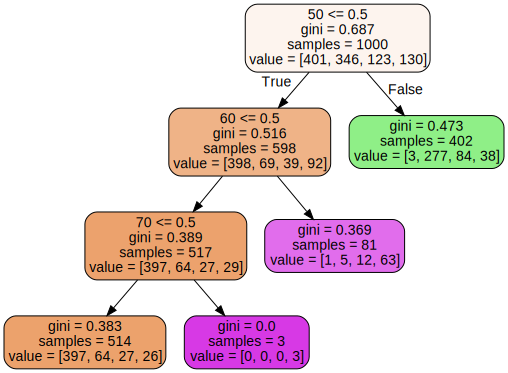

In [59]:
cart_graph = Source(export_graphviz(clf,
                                    feature_names = X_train.columns,
                                    rounded = True, proportion = False, 
                                    filled = True))
SVG(cart_graph.pipe(format='svg'))

# CART - speed + lanes + selfsup-emb

## Naive

In [270]:
X, y = load_data(df, ['speed_limit', 'nlanes'])
emb_train, _ = load_emb('8763825_290', 'training')
emb_test, _ = load_emb('8763825_290', 'test')
X_train = np.concatenate([X.iloc[indi_train, :].values, emb_train], axis=1)
X_test = np.concatenate([X.iloc[indi_test, :].values, emb_test], axis=1)
y_train = y.iloc[indi_train]
y_test = y.iloc[indi_test]

In [271]:
clf = DecisionTreeClassifier(random_state=0, max_depth=10)
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.9011566388149013, 0.789545377149668)

In [272]:
confusion_matrix(y_test, clf.predict(X_test), normalize='true')

array([[0.91652824, 0.05523256, 0.02242525, 0.00581395],
       [0.1207824 , 0.79168704, 0.0806846 , 0.00684597],
       [0.0921895 , 0.35083227, 0.3943662 , 0.16261204],
       [0.01564945, 0.03442879, 0.1627543 , 0.78716745]])

## Grid Search

In [264]:
dt_clf = DecisionTreeClassifier(random_state=0)
params = {'criterion': ['gini', 'entropy'],
          'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
          'min_samples_split': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2]}

clf = GridSearchCV(dt_clf, params, cv=5)
search = clf.fit(X_train, y_train)
search.best_params_

{'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 0.01}

In [273]:
dt_clf = DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=7, min_samples_split=0.01)
dt_clf.fit(X_train, y_train)
dt_clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.865654759732915, 0.789545377149668)

# CART - Type + Cycle

In [229]:
X, y = load_data(df, ['infras', 'road_type'])
X_train = X.iloc[indi_train, :]
y_train = y.iloc[indi_train]
X_test = X.iloc[indi_test, :]
y_test = y.iloc[indi_test]

In [230]:
clf = DecisionTreeClassifier(random_state=0, max_depth=10)
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.5718247163133506, 0.575174527498723)

In [231]:
confusion_matrix(y_test, clf.predict(X_test), normalize='true')

array([[0.34260797, 0.62167774, 0.02491694, 0.01079734],
       [0.01515892, 0.79217604, 0.15207824, 0.0405868 ],
       [0.04993598, 0.05633803, 0.45070423, 0.44302177],
       [0.01408451, 0.03442879, 0.04225352, 0.90923318]])

## Grid Search

In [171]:
dt_clf = DecisionTreeClassifier(random_state=0)
params = {'criterion': ['gini', 'entropy'],
          'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
          'min_samples_split': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2]}

clf = GridSearchCV(dt_clf, params, cv=5)
search = clf.fit(X_train, y_train)
search.best_params_

{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 0.01}

In [170]:
dt_clf = DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=5, min_samples_split=0.01)
dt_clf.fit(X_train, y_train)
dt_clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.5724459134615385, 0.575174527498723)

# Random Forest

## Naive

In [174]:
clf = RandomForestClassifier(random_state=0, n_estimators=100)
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.5724459134615385, 0.575174527498723)

## Grid Search

In [176]:
rf_clf = RandomForestClassifier(random_state=0)
params = {'criterion': ['gini', 'entropy'],
          'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
          'min_samples_split': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2],
          'max_features': ['sqrt', 'log2'],
          'n_estimators': [10, 30, 50, 70, 100, 130, 150, 170, 200]}

clf = GridSearchCV(rf_clf, params, cv=5)
search = clf.fit(X_train, y_train)
search.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'sqrt',
 'min_samples_split': 0.03,
 'n_estimators': 10}

In [177]:
clf = RandomForestClassifier(random_state=0, n_estimators=10, max_features='sqrt', min_samples_split=0.03, max_depth=6, criterion='gini')
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.5723557692307693, 0.5748339860378001)